In [1]:
# single

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint

    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)
    

C:\Users\tcumi\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.9382716049382716, Loss: 0.3049202671757451
Checkpoint 200, Accuracy: 0.9691358024691358, Loss: 0.25748574292218246
Checkpoint 300, Accuracy: 0.9629629629629629, Loss: 0.2182066175672743
Checkpoint 400, Accuracy: 0.9691358024691358, Loss: 0.16953185752586084
Checkpoint 500, Accuracy: 0.9691358024691358, Loss: 0.14381798991450556


In [10]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 0. 1.] <-> [3.0618874e-02 9.2128123e-04 9.6845978e-01]
[1. 0. 0.] <-> [0.9860962  0.00263184 0.01127193]
[0. 1. 0.] <-> [0.11360609 0.8833125  0.00308134]
[1. 0. 0.] <-> [0.9701141  0.01608987 0.01379591]
[0. 0. 1.] <-> [0.7885048  0.00266413 0.2088311 ]
[1. 0. 0.] <-> [0.976194   0.00299501 0.02081093]
[1. 0. 0.] <-> [0.9795687  0.00645433 0.01397704]
[1. 0. 0.] <-> [0.9746436  0.00249584 0.02286059]
[1. 0. 0.] <-> [0.98423105 0.00342583 0.0123432 ]
[1. 0. 0.] <-> [0.9843322  0.00295654 0.01271126]
[1. 0. 0.] <-> [0.92105067 0.00446254 0.07448682]
[1. 0. 0.] <-> [0.854421   0.12961185 0.01596717]
[0. 1. 0.] <-> [0.01045932 0.98560995 0.00393079]
[1. 0. 0.] <-> [0.98354197 0.00450768 0.01195038]
[0. 1. 0.] <-> [0.37321723 0.6189054  0.00787739]
[1. 0. 0.] <-> [0.6462782  0.00695549 0.3467664 ]
[0. 1. 0.] <-> [0.13000003 0.8656007  0.00439931]
[0. 1. 0.] <-> [0.02729592 0.96821845 0.0044856 ]
[1. 0. 0.] <-> [0.9757756  0.00761684 0.01660753]
[1. 0. 0.] <-> [0.9777851  0.00932003 0.0

In [12]:
# Testing Performance

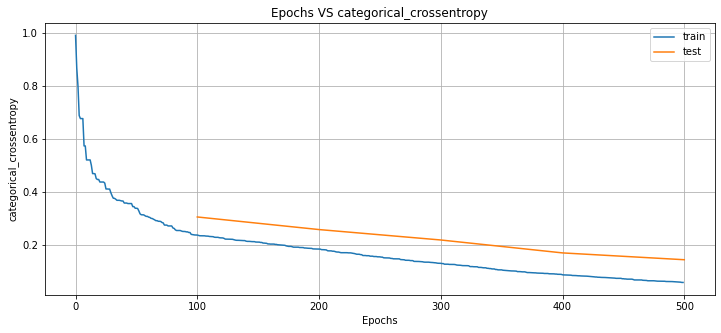

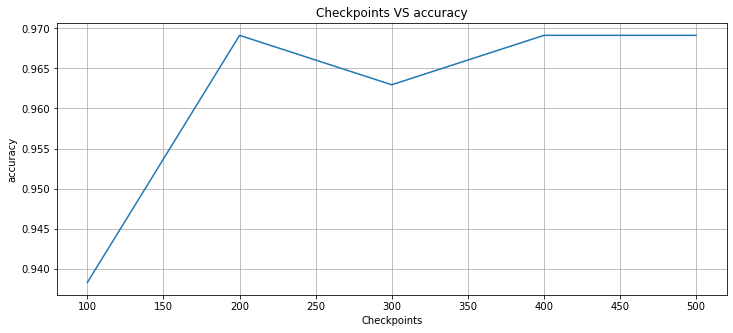

In [13]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9382716049382716, 'mean_square_error': 0.1566284460539364, 'categorical_crossentropy': 0.3049202671757451, 'precision': 0.9074074074074074, 'recall': 0.9074074074074074, 'f1': 0.9074074074074074, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 9, 'tn_hit': 21, 'fn_hit': 1}, 1: {'tp_hit': 13, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 3}, 2: {'tp_hit': 8, 'fp_hit': 1, 'tn_hit': 93, 'fn_hit': 6}}, 'checkpoint': 100} 


{'accuracy': 0.9691358024691358, 'mean_square_error': 0.1300804336139306, 'categorical_crossentropy': 0.25748574292218246, 'precision': 0.9537037037037037, 'recall': 0.9537037037037037, 'f1': 0.9537037037037037, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 4, 'tn_hit': 26, 'fn_hit': 1}, 1: {'tp_hit': 14, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 2}, 2: {'tp_hit': 12, 'fp_hit': 1, 'tn_hit': 93, 'fn_hit': 2}}, 'checkpoint': 200} 


{'accuracy': 0.9629629629629629, 'mean_square_error': 0.11092614764429483, 'categorical_crossentropy': 0.2182066175672743, 'precision'

In [15]:
print(model)

Layer 1
Neuron 0: weights:
[-0.85898143 -0.33801183  2.5244133   2.309868    1.4645778 ]
 bias: -0.2674199640750885

Neuron 1: weights:
[ 1.5020698  -2.8931499  -1.1489829  -0.41700402 -1.0977132 ]
 bias: 1.4948217868804932

Neuron 2: weights:
[-1.2139223  1.9448057  2.461564  -1.415973  -2.3762321]
 bias: -2.3162765502929688

Neuron 3: weights:
[ 0.46579823 -2.7309518  -0.53664386  1.8538079   2.8641875 ]
 bias: -2.2218217849731445

$
Layer 2
Neuron 0: weights:
[-3.         2.9950058 -3.        -2.9648118]
 bias: 2.0887606143951416

Neuron 1: weights:
[-0.85518485  0.13544196  3.         -1.9451349 ]
 bias: -1.4441946744918823

Neuron 2: weights:
[-0.23417394  1.7438489  -3.          3.        ]
 bias: -1.5770809650421143

$

